In [3]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import math
import pandas as pd
from numpy.fft import fft, ifft,fftshift
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model
#from fancyimpute import SoftImpute
import time

In [2]:
def periodic_corr(x, y):
    """Periodic correlation, implemented using the FFT.

    x and y must be real sequences with the same length.
    """
    n1 = len(x)
    n2 = len(y)
    a = n1*[0]
    b = n2*[0]
    x = x.tolist()
    x.extend(a)
    y = y.tolist()
    y.extend(b)
    result = fftshift(ifft(fft(x) * fft(y).conj()))
    result = result.tolist()
    return result

def gaussian_filter(low_freq,high_freq,window_size,Fs):
    # % Index of low frequency and high frequency in the positive
    #% frequency domain
    ind_low = round(low_freq * window_size/ Fs) + 1
    ind_high = round(high_freq * window_size / Fs) + 1
    filter = [0]*window_size
    sigma = (ind_high - ind_low) / 6
    mean = (ind_high - ind_low) / 2
    gaussian_window = stats.norm.pdf([i+1 for i in range(ind_high - ind_low)], loc=mean, scale=sigma)
    # Positive freq part
    a = [1]*(ind_high - ind_low)
    filter[ind_low-1: ind_high - 1] = a * gaussian_window
    # Negative freq part
    filter[window_size - ind_high : window_size - ind_low] = a * gaussian_window
    return filter

In [3]:
def lag_mat(beta,a,b,sigma,delta,threshold_origin):
    x = [beta * i for i in a]
    y = [beta * i for i in b]
    length = len(a)
    window_size = 5 * 60 * 50
    '''
    low_freq = 0
    high_freq = 0.5
    Fs = 100
    filter_Y = gaussian_filter(low_freq, high_freq, window_size * 2, Fs)
    '''
    distance = []
    for i in range(length):
        distance.append(np.sqrt((beta*50)**2 + x[i]**2 + y[i]**2))

    threshold = beta * threshold_origin
    mudistance = np.zeros((length,length))
    for i in range(length):
        for j in range(length):
            if i<j:
                d = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2)
                if d<threshold:
                    mudistance[i,j] = d
    #print(mudistance)
    '''
    w_sigma = window_size / 2
    w_mean = window_size / 2
    gaussian_window = stats.norm.pdf([i+1 for i in range(window_size)],loc = w_mean,scale = w_sigma)
    '''
    lag = distance
    mean = []
    for i in range(length):
        mean.append(7000 + lag[i])
    #print(mean)

    data = []
    for i in range(length):
        data.append(stats.norm.pdf([t + 1 for t in range(window_size)], loc=mean[i], scale=sigma))

    mat = np.zeros((length,length))
    for i in range(length):
        data_prac = []
        data_prac.append(data[i] / np.max(abs(data[i])))
        for j in range(length):
            if mudistance[i,j] != 0:
                data_prac.append(data[j] / np.max(abs(data[j])) + delta * np.random.randn(window_size) * mudistance[i,j]/threshold)#*gaussian_window)
            else:
                data_prac.append(0)
        for k in range(length):
            if type(data_prac[k+1]) == int:
                continue
            elif i != k:
                Y = np.array(periodic_corr(data_prac[0],data_prac[k+1]))
                '''
                frq_Y = fft(Y)
                frq_Y = frq_Y * filter_Y
                Y_filter = ifft(frq_Y).real
                '''
                # plt.plot(Y.real)
                # num - abs(Y.real).tolist().index(max(abs(Y.real)))
                FFT = fft(Y)
                angle = np.angle(FFT[:80])
                angle_odd = [angle[2 * i + 1] for i in range(40)]
                # plt.plot(np.unwrap(angle_even))
                # plt.plot(np.unwrap(angle_odd))
                reg = linear_model.LinearRegression()
                angle_odd = np.unwrap(angle_odd)
                reg.fit(np.array([i for i in range(40)]).reshape(-1,1),angle_odd)
                mat[i,k] = reg.coef_

    for i in range(length):
        for j in range(length):
            if i > j:
                mat[i,j] = -mat[j,i]
    #print(mat)
    X = np.array([[np.exp(mat[i][j]) for j in range(len(mat[i]))] for i in range(len(mat))])
    return X

Text(0.5,0,'z axis')

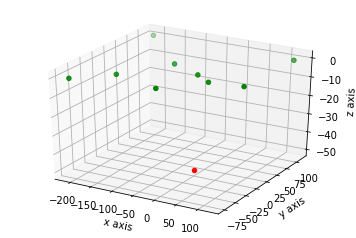

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(111,projection='3d')
#x = [2,30,-14,53,106,-77,8,-59,-213,-306,-122,234,160,88,-26,62]
#y = [6,27,18,-21,-5,56,31,-17,112,-75,-107,167,-255,233,-58,-133]
#z = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
x = [2,-74,43,116,-139,-213,-206,122,-26]
y = [6,28,-11,-5,-37,112,-75,107,-58]
z = [0,0,0,0,0,0,0,0,0]
ax1.scatter(0,0,-50,c='r',marker='o')
ax1.scatter(x,y,z,c='g',marker='o')
ax1.set_xlabel('x axis')
ax1.set_ylabel('y axis')
ax1.set_zlabel('z axis')
#plt.savefig('/home/danye/outcome/3D_simulation_stations.png')

In [5]:
distance = []
for i in range(len(z)):
    distance.append(math.sqrt(50**2 + x[i]**2 + y[i]**2))
print(distance)

[50.39841267341661, 93.59487165438073, 66.85805860178712, 126.41598000252975, 152.28263197095066, 245.79056125083403, 224.8577328000974, 169.8028268315931, 80.87026647662292]


In [6]:
X = lag_mat(1,x,y, 100, 0,300)

In [7]:
#beta = [(i + 1)/3 for i in range(10)]
beta = [1/2,1,3/2]
sigma = 100
#delta = np.sqrt([(i+1)/1000 for i in range(10)])
#delta = [(i+3)/50 for i in range(10)]
delta = [(i+1)/200 for i in range(20)]
threshold_origin = 300
#beta = [1/2]
#delta = [0.05]

In [8]:
length = len(x)
#softimpute = SoftImpute(init_fill_method = 'mean',verbose=False,shrinkage_value=0.0011,convergence_threshold=0.0001) 
X = lag_mat(1,x,y, sigma, 0,threshold_origin)
X_incomplete = X.copy()
for i in range(length):
    for j in range(length):
        if X[i,j] == 1 and i != j:
            X_incomplete[i,j] = np.nan
k = np.sum(np.isnan(X_incomplete))
missing_mask = np.isnan(X_incomplete)
print(k)
print(missing_mask)

8
[[False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False  True  True False False]
 [False False False False False False False False False]
 [False False False  True False False False  True False]
 [False False False  True False False False  True False]
 [False False False False False  True  True False False]
 [False False False False False False False False False]]


In [9]:
start = time.time()
error = np.zeros((len(beta),len(delta)))
for t in range(1000):
    for i in range(len(beta)):
        if i == 0:
            softimpute = SoftImpute(init_fill_method = 'mean',verbose=False,shrinkage_value=0.0006,convergence_threshold=0.0001) 
        elif i == 1:
            softimpute = SoftImpute(init_fill_method = 'mean',verbose=False,shrinkage_value=0.0011,convergence_threshold=0.0001) 
        else:
            softimpute = SoftImpute(init_fill_method = 'mean',verbose=False,shrinkage_value=0.0017,convergence_threshold=0.0001)
        X_origin = lag_mat(beta[i],x,y, sigma, 0,1000)
        #print(X_origin[missing_mask])
        for j in range(len(delta)):
            error_mat = 10000000
            while error_mat/81 > 0.000001 :
                X = lag_mat(beta[i],x,y, sigma, delta[j],threshold_origin)
                X_incomplete = X.copy()
                '''
                for u in range(length):
                    for v in range(length):
                        if X[u,v] == 1 and u != v:
                            X_incomplete[u,v] = np.nan
                '''
                X_incomplete[missing_mask] = np.nan
                #print(X_incomplete[missing_mask])
                X_filled = softimpute.complete(X_incomplete)
                #print(X_filled[missing_mask])
                #error_mat = np.array([[(np.log(X_origin[i][j]) - np.log(X_filled[i][j])) ** 2 for j in range(len(X[i]))] for i in range(len(X))])
                #error_mat = np.sum((X_origin[missing_mask]-X_filled[missing_mask])**2)
                error_mat = np.sum((np.log(X_origin)-np.log(X_filled))**2)
                #print(error_mat/81)
                #print(error_mat/k)
            error[i,j] = error[i,j] + error_mat/81
    print(error[0,0])
end = time.time()
print(end-start)

1.9739593403978148e-09
3.814793076641993e-09
5.35517954316067e-09
7.340677188345865e-09
9.065837865552627e-09
1.0907105928756087e-08
1.280555843269394e-08
1.4219454544041876e-08
1.5886901552970025e-08
1.7403659900297117e-08
1.8958409145743395e-08
2.1168161211253077e-08
2.2274624446033013e-08
2.354496551380226e-08
2.4852344774336914e-08
2.6300750187889058e-08
2.8541908870380867e-08
3.018814714629827e-08
3.2194112446465375e-08
3.415704348804876e-08
3.628279225222556e-08
3.87327579548477e-08
4.0448174983750333e-08
4.225198534985181e-08
4.413386202670455e-08
4.5404972888726046e-08
4.7641915499583824e-08
4.9741039981621286e-08
5.159393245395413e-08
5.3389116808595545e-08
5.5091680408584817e-08
5.657871734686718e-08
5.898707084025103e-08
6.065444945127355e-08
6.226278246143465e-08
6.39125694288797e-08
6.562065559907097e-08
6.710751208643149e-08
6.862402891872749e-08
7.008676873981925e-08
7.187741720988253e-08
7.400880690484559e-08
7.573056520343466e-08
7.755338354089284e-08
7.929768541941385

6.516443170483648e-07
6.534367326773269e-07
6.549188118541573e-07
6.56820821960718e-07
6.587334534619724e-07
6.604255872450619e-07
6.620292688943185e-07
6.638317573100322e-07
6.658104608521695e-07
6.675873152989457e-07
6.701297423749331e-07
6.71540688515494e-07
6.730121350607563e-07
6.749480420857874e-07
6.771534970124327e-07
6.792650830735915e-07
6.80822050254428e-07
6.825624798633697e-07
6.839599905922204e-07
6.855031774630829e-07
6.871954699753996e-07
6.887387591017362e-07
6.904939766914264e-07
6.926257853449924e-07
6.941164935234352e-07
6.961166114902544e-07
6.981396017161014e-07
7.002368542685599e-07
7.015025974057102e-07
7.034820135466994e-07
7.053314069041285e-07
7.069116247524892e-07
7.083613763676372e-07
7.102457713455782e-07
7.129248052888663e-07
7.144421894711805e-07
7.160339781672292e-07
7.176169728364408e-07
7.191538848304705e-07
7.207791686875563e-07
7.225191323244944e-07
7.240115313972437e-07
7.256213783344619e-07
7.276451947312792e-07
7.293453351881759e-07
7.31149063593

1.3032913995387398e-06
1.3048371767009976e-06
1.3062957590250617e-06
1.3087694990193203e-06
1.3104217232888343e-06
1.3123511600928354e-06
1.314030140876667e-06
1.3163463928159608e-06
1.3178207645475512e-06
1.3194032402944864e-06
1.3210564784768573e-06
1.3227427323523488e-06
1.324941046659933e-06
1.3268554518983877e-06
1.3286528215815418e-06
1.3302503099110073e-06
1.3318158958574394e-06
1.3336357622588708e-06
1.3352502819410643e-06
1.337037230769698e-06
1.3390515541972878e-06
1.3407573950459376e-06
1.3425587768141283e-06
1.3445249163219278e-06
1.3470365197188743e-06
1.3483841076827712e-06
1.3497451117655353e-06
1.3524530639610856e-06
1.3541630045428496e-06
1.3558320223917444e-06
1.3574070874765646e-06
1.358999503508217e-06
1.3603303362455445e-06
1.361635311092928e-06
1.3634253968678244e-06
1.3649372739973869e-06
1.3664764560940083e-06
1.3680594756074854e-06
1.3701495447470445e-06
1.3718368814728625e-06
1.3738269823682841e-06
1.3753711499255193e-06
1.3769768035388632e-06
1.37855665360628

In [ ]:
#print(np.log(X)*75/np.pi)
print(np.log(X_incomplete)*75/np.pi)
#print(i)
#print(j)
print(np.log(X_origin)*75/np.pi)
#print(lag_mat(beta[8], lag_origin, mean, sigma, delta[6]))
print(np.log(X_filled)*75/np.pi)
#print(np.log(X)-np.log(X_filled))
print(np.sum(np.log(X)-np.log(X_filled)))

In [1]:
np.save("/home/danye/outcome/new3D_simulation_error1000_0.511.5.npy",error)

NameError: name 'np' is not defined

In [5]:
error = np.load('C:/Users/Admin/Desktop/fsdownload/new3D_simulation_error1000_0.511.5.npy')

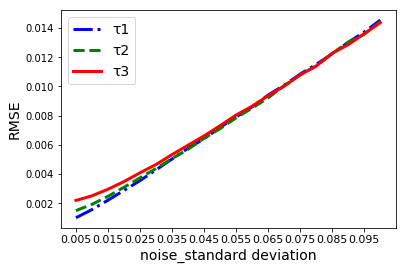

In [19]:
error_new = np.sqrt(error/1000)*75/np.pi
plt.plot(error_new[0],'-.',label = 'τ1',linewidth = 3,c = 'b')
plt.plot(error_new[1],'--',label = 'τ2',linewidth = 3,c = 'g')
plt.plot(error_new[2],label = 'τ3',linewidth = 3,c = 'r')
plt.xticks(fontsize=11)
plt.yticks(fontsize=10)
plt.xlabel('noise_standard deviation',fontsize = 14)
plt.ylabel('RMSE',fontsize = 14)
plt.xticks([2*i for i in range(10)],[(1 + 2*i)/200  for i in range(10)])
plt.legend(loc='upper left',fontsize = 14)
plt.savefig('C:/Users/Admin/Desktop/fsdownload/3DRMSE.png')

In [ ]:
print(error)
#error_new = (np.sqrt(error/1))
error_new = (np.sqrt(error/1)*75/np.pi)
print(error_new)
plt.imshow(error_new[:,:], cmap='gray_r')
plt.colorbar(shrink=0.8)
plt.xlabel('noise_variance')
plt.ylabel('lag')

In [ ]:
error100_1 = np.load("/home/danye/outcome/3D_simulation_error100_1.npy")
error100_2 = np.load("/home/danye/outcome/3D_simulation_error100_2.npy")
error100_3 = np.load("/home/danye/outcome/3D_simulation_error100_3.npy")
error50_1 = np.load("/home/danye/outcome/3D_simulation_error50_1.npy")
error150_1 = np.load("/home/danye/outcome/3D_simulation_error150_1.npy")
error200_1 = np.load("/home/danye/outcome/3D_simulation_error200_1.npy")
error300_1 = np.load("/home/danye/outcome/3D_simulation_error300_1.npy")

In [ ]:
error = error100_1 + error100_2 + error100_3 + error50_1 + error150_1 + error200_1 + error300_1
error_new = (np.sqrt(error/1000))
plt.imshow(error_new[:,:], cmap='gray_r')
#new_yticks = np.linspace(0,8,5)
plt.colorbar(shrink=0.8)
plt.xlabel('noise_standard deviation')
plt.ylabel('lag_beta')
#plt.yticks(new_yticks)
plt.yticks(np.arange(0, 10, 2),[0.33,1.0,1.67,2.33,3])
plt.xticks(np.arange(0, 10, 2),[0.06 + i * 0.04 for i in range(5)])
#beta = [(i + 1)/3 for i in range(10)]
#delta = [(i+3)/50 for i in range(10)]
plt.savefig('/home/danye/outcome/3D_simulation_error1000_final.png')

In [ ]:
np.arange(0, 10, 2)